# **Hurricane Harvey Challenge [DSBA 2022-2023]**

By: Nhat Mai NGUYEN and Vanshika SHARMA

# 1. Import & explore data

### 1.1 Import data

In [ ]:
! mkdir Hurricane_Harvey 
! mkdir Hurricane_Harvey/rasters Hurricane_Harvey/vectors 
! gsutil -m cp -n -r gs://geoengine-dataset-houston-uav/rasters/raw Hurricane_Harvey/rasters/ 
! gsutil -m cp -n -r gs://geoengine-dataset-houston-uav/vectors/random-split-_2022_11_17-22_35_45/ Hurricane_Harvey/vectors/

mkdir: cannot create directory ‘Hurricane_Harvey’: File exists
mkdir: cannot create directory ‘Hurricane_Harvey/rasters’: File exists
mkdir: cannot create directory ‘Hurricane_Harvey/vectors’: File exists
Skipping existing item: file://Hurricane_Harvey/rasters/raw/10171.tif
Skipping existing item: file://Hurricane_Harvey/rasters/raw/10172.tif
Skipping existing item: file://Hurricane_Harvey/rasters/raw/10170.tif
Skipping existing item: file://Hurricane_Harvey/rasters/raw/10184.tif
Skipping existing item: file://Hurricane_Harvey/rasters/raw/10174.tif
Skipping existing item: file://Hurricane_Harvey/rasters/raw/6414.tif
Skipping existing item: file://Hurricane_Harvey/rasters/raw/10300.tif
Skipping existing item: file://Hurricane_Harvey/rasters/raw/10566.tif
Skipping existing item: file://Hurricane_Harvey/rasters/raw/10808.tif
Skipping existing item: file://Hurricane_Harvey/rasters/raw/10814.tif
Skipping existing item: file://Hurricane_Harvey/rasters/raw/10817.tif
Skipping existing item: fi

### 1.2 Import libraries

In [ ]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
!pip install segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%matplotlib inline
from PIL import Image
from osgeo import gdal
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
import pandas as pd
import json
import os
import glob
import shutil
import cv2
import tarfile

import torch
import torchvision.transforms as T
import torchvision
from torch.utils.data.dataset import Dataset
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import torch.nn as nn
import segmentation_models_pytorch as smp
import albumentations as A

### 1.3 Explore data

Image size: (3000, 4000, 3)


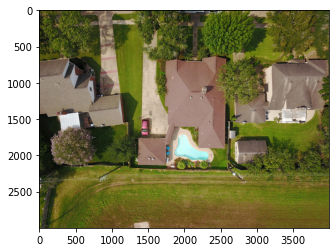

In [ ]:
# Visualize data in raster/raw folder
img_10170 = gdal.Open(r'Hurricane_Harvey/rasters/raw/10170.tif')
band1 = img_10170.GetRasterBand(1) # Red channel
band2 = img_10170.GetRasterBand(2) # Green channel
band3 = img_10170.GetRasterBand(3) # Blue channel

b1 = band1.ReadAsArray()
b2 = band2.ReadAsArray()
b3 = band3.ReadAsArray()

img = np.dstack((b1, b2, b3))
print("Image size:" ,img.shape)
f = plt.figure()
plt.imshow(img)
plt.show()

In [ ]:
# Check json file in vectors/COCO
f = open ('Hurricane_Harvey/vectors/random-split-_2022_11_17-22_35_45/COCO/6373eb4cbfe85a8192f99acf.json', "r")
data = json.loads(f.read())
data

{'info': {'version': '1.0',
  'description': 'Synthetic and real data for Human Aid and Disaster Relief for residential area flooding scenarios.',
  'date': '2022-11-15 19:40:59.838000',
  'year': 2022,
  'id': '6373eb4cbfe85a8192f99acf',
  'bbox': []},
 'images': [{'id': '0',
   'name': '10170',
   'width': 4000,
   'height': 3000,
   'file_name': 'gs://geoengine-dataset-houston-uav/rasters/10170.tif',
   'date_captured': '2017-08-31 00:00:00'}],
 'annotations': [{'id': '63740567f24e74699fd6c57c',
   'area': 734467.0,
   'bbox': [-1.0, 660.0, 1181.0, 1027.0],
   'segmentation': [[4.0,
     1433.0,
     97.0,
     1427.0,
     129.0,
     1473.0,
     262.0,
     1450.0,
     311.0,
     1687.0,
     1180.0,
     1568.0,
     1117.0,
     1158.0,
     784.0,
     1202.0,
     750.0,
     1276.0,
     663.0,
     1072.0,
     709.0,
     869.0,
     538.0,
     895.0,
     492.0,
     1089.0,
     426.0,
     939.0,
     488.0,
     741.0,
     410.0,
     748.0,
     344.0,
     940.0,

In [ ]:
# Check the csv folder
f = open ('Hurricane_Harvey/vectors/random-split-_2022_11_17-22_35_45/CSV/metadata.json', "r")
data = json.loads(f.read())
data

{'id': '6373eb4b7930b27221315989',
 'title': 'Hurricane Harvey',
 'description': 'Synthetic and real data for Human Aid and Disaster Relief for residential area flooding scenarios.',
 'tags': ['UAV', 'Disaster', 'Flood', 'Synthetic'],
 'problem_type': 'segmentation',
 'label:metadata': [{'title': 'Label',
   'description': '',
   'options': ['Property Roof',
    'Secondary Structure',
    'Swimming Pool',
    'Vehicle',
    'Grass',
    'Trees / Shrubs',
    'Solar Panels',
    'Chimney',
    'Street Light',
    'Window',
    'Satellite Antenna',
    'Garbage Bins',
    'Trampoline',
    'Road / Highway',
    'Under Construction / In Progress Status',
    'Power Lines & Cables',
    'Bridge',
    'Water Tank / Oil Tank',
    'Parking Area - Commercial',
    'Sports Complex / Arena',
    'Industrial Site',
    'Dense Vegetation / Forest',
    'Water Body',
    'Flooded',
    'Boat',
    'Parking Area'],
   'scope': 'polygon',
   'date_dependent': False,
   'is_multilabel': False}],
 'da

In [ ]:
# Create label_list
label_list = data['label:metadata'][0]['options']
label_dict = {k: v for v, k in enumerate(label_list)}
label_dict

{'Property Roof': 0,
 'Secondary Structure': 1,
 'Swimming Pool': 2,
 'Vehicle': 3,
 'Grass': 4,
 'Trees / Shrubs': 5,
 'Solar Panels': 6,
 'Chimney': 7,
 'Street Light': 8,
 'Window': 9,
 'Satellite Antenna': 10,
 'Garbage Bins': 11,
 'Trampoline': 12,
 'Road / Highway': 13,
 'Under Construction / In Progress Status': 14,
 'Power Lines & Cables': 15,
 'Bridge': 16,
 'Water Tank / Oil Tank': 17,
 'Parking Area - Commercial': 18,
 'Sports Complex / Arena': 19,
 'Industrial Site': 20,
 'Dense Vegetation / Forest': 21,
 'Water Body': 22,
 'Flooded': 23,
 'Boat': 24,
 'Parking Area': 25}

In [ ]:
train_data = pd.read_csv('Hurricane_Harvey/vectors/random-split-_2022_11_17-22_35_45/CSV/train.csv',index_col=[0]) 
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22419 entries, 0 to 3293
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image-id  22419 non-null  object
 1   image:01  22419 non-null  object
 2   date:01   22419 non-null  object
 3   type      22419 non-null  object
 4   geometry  22419 non-null  object
 5   label     22419 non-null  object
dtypes: object(6)
memory usage: 1.2+ MB


In [ ]:
train_data['label_id'] = train_data['label'].map(label_dict)
train_data.head()

,image-id,image:01,date:01,type,geometry,label,label_id
0,6373eb4cbfe85a8192f99b74,gs://geoengine-dataset-houston-uav/rasters/719...,2017-08-31T00:00:00+00:00,polygon,121 1709 105 1842 97 2070 383 2094 369 2580 10...,Property Roof,0
1,6373eb4cbfe85a8192f99b74,gs://geoengine-dataset-houston-uav/rasters/719...,2017-08-31T00:00:00+00:00,polygon,2716 2336 2877 2527 2939 2504 2953 2460 2927 2...,Vehicle,3
2,6373eb4cbfe85a8192f99b74,gs://geoengine-dataset-houston-uav/rasters/719...,2017-08-31T00:00:00+00:00,polygon,2809 2171 3002 2419 3099 2363 3044 2287 2962 2...,Vehicle,3
3,6373eb4cbfe85a8192f99b74,gs://geoengine-dataset-houston-uav/rasters/719...,2017-08-31T00:00:00+00:00,polygon,3399 2922 3468 2918 3628 2952 3696 2894 3902 2...,Property Roof,0
4,6373eb4cbfe85a8192f99b74,gs://geoengine-dataset-houston-uav/rasters/719...,2017-08-31T00:00:00+00:00,polygon,2826 1633 3063 1909 3136 1872 3245 1772 3047 1...,Secondary Structure,1


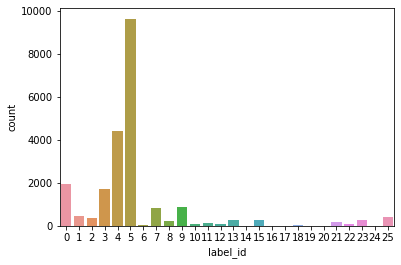

In [ ]:
sns.countplot(x=train_data['label_id']) # => unbalanced => 14,16,17,19,20,24

In [ ]:
val_data = pd.read_csv('Hurricane_Harvey/vectors/random-split-_2022_11_17-22_35_45/CSV/val.csv',index_col=[0]) 
val_data

,image-id,image:01,date:01,type,geometry,label


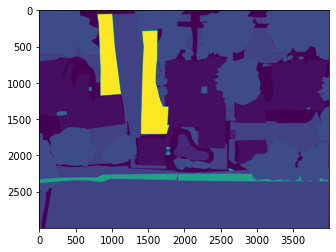

In [ ]:
# Check the mask folder
img = mpimg.imread('Hurricane_Harvey/vectors/random-split-_2022_11_17-22_35_45/Masks/10170.png')
plt.imshow(img)

In [ ]:
# Check number of training and test images
print(len(os.listdir('Hurricane_Harvey/rasters/raw'))) # 299 training images & 75 testing images
print(len(os.listdir('Hurricane_Harvey/vectors/random-split-_2022_11_17-22_35_45/Masks'))) # masks for 299 training images

374
299


### 1.4 Data cleaning & loading

In [ ]:
# Create folder to store train, validation & test images
!mkdir train_image
!mkdir val_image
!mkdir test_image

mkdir: cannot create directory ‘train_image’: File exists
mkdir: cannot create directory ‘val_image’: File exists
mkdir: cannot create directory ‘test_image’: File exists


In [ ]:
# Create a list of training image names
train_data["image_name"] = train_data["image:01"].str.split('rasters/').str[-1]
train_img_list = train_data["image_name"].unique()
print(train_img_list[0:5])
len(train_img_list)

['7194.tif' '8937.tif' '7575.tif' '8445.tif' '6666.tif']


299

In [ ]:
# Choose images for validation
val_img_list = [6414,6420,6433,6444,6468,6556,6565,6640,6715,7691,8368,8447,8817,8902,7233,
                6706,7256,7315,7321,7336,7525,7575,8917,8955,9107,6820,6843,6905,6966,6969]

In [ ]:
# Assign images into correct train, validation & test folders
src_dir = "Hurricane_Harvey/rasters/raw"

for tiffile in glob.iglob(os.path.join(src_dir, "*.tif")):
  if tiffile.split('raw/')[-1] in train_img_list:
    if int(tiffile.split('raw/')[-1].replace(".tif","")) in val_img_list:
      dst_dir = "val_image"
    else:
      dst_dir = "train_image"
  else:
    dst_dir = "test_image"
  shutil.copy(tiffile, dst_dir)

print("# of training image:",len(os.listdir('train_image')))
print("# of validation image:",len(os.listdir('val_image')))
print("# of testing image:",len(os.listdir('test_image')))

# of training image: 278
# of validation image: 21
# of testing image: 75


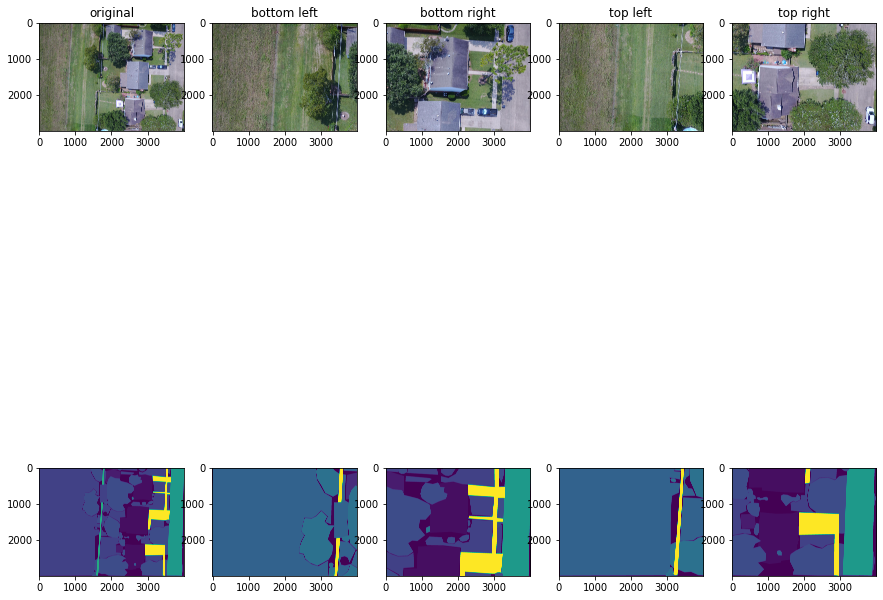

In [ ]:
# Create function to split image to oversampling under-represented classes
def split_img_into4(img_dir,mask_img_dir):
  img   = mpimg.imread(img_dir)
  mask  = mpimg.imread(mask_img_dir)
  size = (img.shape[1], img.shape[0]) # for resize later
  h, w, channels = img.shape
  half_w = w//2 # vertical split
  half_h = h//2 # horizontal split
  # Split 1 image into 4 & resize
  top_left_img = cv2.resize(img[half_h:, :half_w], size, interpolation = cv2.INTER_NEAREST)
  top_right_img = cv2.resize(img[half_h:, half_w:], size, interpolation = cv2.INTER_NEAREST)
  bottom_left_img = cv2.resize(img[:half_h, :half_w], size, interpolation = cv2.INTER_NEAREST)
  bottom_right_img = cv2.resize(img[:half_h, half_w:], size, interpolation = cv2.INTER_NEAREST)
  # Split 1 mask into 4 & resize
  top_left_mask = cv2.resize(mask[half_h:, :half_w], size, interpolation = cv2.INTER_NEAREST)
  top_right_mask = cv2.resize(mask[half_h:, half_w:], size, interpolation = cv2.INTER_NEAREST)
  bottom_left_mask = cv2.resize(mask[:half_h, :half_w], size, interpolation = cv2.INTER_NEAREST)
  bottom_right_mask = cv2.resize(mask[:half_h, half_w:], size, interpolation = cv2.INTER_NEAREST)
  return top_left_img,top_right_img,bottom_left_img,bottom_right_img,top_left_mask,top_right_mask,bottom_left_mask,bottom_right_mask

# Test function
img_dir ='train_image/6648.tif'
mask_img_dir = 'Hurricane_Harvey/vectors/random-split-_2022_11_17-22_35_45/Masks/6648.png'
top_left_img,top_right_img,bottom_left_img,bottom_right_img,top_left_mask,top_right_mask,bottom_left_mask,bottom_right_mask = split_img_into4(img_dir,mask_img_dir)
img   = mpimg.imread(img_dir)
mask  = mpimg.imread(mask_img_dir)

f,ax = plt.subplots(2,5, figsize=(15,15))
ax[0][0].imshow(img)
ax[0][0].set_title("original")
ax[0][1].imshow(bottom_left_img)
ax[0][1].set_title("bottom left")
ax[0][2].imshow(bottom_right_img)
ax[0][2].set_title("bottom right")
ax[0][3].imshow(top_left_img)
ax[0][3].set_title("top left")
ax[0][4].imshow(top_right_img)
ax[0][4].set_title("top right")
ax[1][0].imshow(mask)
ax[1][1].imshow(bottom_left_mask)
ax[1][2].imshow(bottom_right_mask)
ax[1][3].imshow(top_left_mask)
ax[1][4].imshow(top_right_mask)

In [ ]:
# Define function to save images & masks
def save_image_tif(image_array, name, path):
  test_img = Image.fromarray(image_array)
  test_img.save(f"{path}/{name}.tif")

def save_mask_png(image_array, name, path):
  test_mask = image_array*255
  test_mask = test_mask.astype(np.uint8)
  test_mask = Image.fromarray(test_mask)
  test_mask.save(f"{path}/{name}.png")

In [ ]:
# We tried to add images for under-represented labels but it did not help improve the accuracy of the models. Therefore, we don't use these images to save computing time

'''# Create additional images for unbalanced labels
image_folder_path = "Hurricane_Harvey/rasters/raw"
mask_folder_path = "Hurricane_Harvey/vectors/random-split-_2022_11_17-22_35_45/Masks"

mask_img_dir_list = glob.glob(os.path.join(mask_folder_path,'*.png'))
img_dir_list = []
for img_path in mask_img_dir_list: # loop through mask list and import the corresponding image
    img_dir_list.append(os.path.join(image_folder_path,os.path.basename(img_path).replace("png","tif")))

save_train_path = "train_image"
save_mask_path = mask_folder_path

count = 0
for i in range(len(mask_img_dir_list)):
    # Get image & mask directory (for function split)
    img_dir  = img_dir_list[i]
    mask_img_dir = mask_img_dir_list[i]
    # Get image and mask name to save file later
    img_id = img_dir.split('/')[-1].split('.')[0]
    mask_img_id = mask_img_dir.split('/')[-1].split('.')[0]
    # Get set of label in the mask
    mask  = mpimg.imread(mask_img_dir)
    mask_label = mask*255
    mask_label = mask_label.astype("int32")
    mask_label_list = np.unique(mask_label).tolist()
    mask_label_set = set([x-1 for x in mask_label_list]) # minus 1 to map between the label in csv file [0,25] to the real value of pixel in mask [1,26]
    # Check if mask contain the under-represented label => split, resize & save
    if len(set(unbalanced_label).intersection(mask_label_set)) > 0:
        count = count + 4
        top_left_img,top_right_img,bottom_left_img,bottom_right_img,top_left_mask,top_right_mask,bottom_left_mask,bottom_right_mask = split_img_into4(img_dir,mask_img_dir)
        # Save image into train_image folder
        save_image_tif(top_left_img,img_id+'0',save_train_path)
        save_image_tif(top_right_img,img_id+'1',save_train_path)
        save_image_tif(bottom_left_img,img_id+'2',save_train_path)
        save_image_tif(bottom_right_img ,img_id+'3',save_train_path)
        # Save mask into original mask folder
        save_mask_png(top_left_mask,mask_img_id+'0',save_mask_path)
        save_mask_png(top_right_mask,mask_img_id+'1',save_mask_path)
        save_mask_png(bottom_left_mask,mask_img_id+'2',save_mask_path)
        save_mask_png(bottom_right_mask,mask_img_id+'3',save_mask_path)
    if count > 500:
      break
                 
print('Additional', count, 'samples created')'''

'# Create additional images for unbalanced labels\nimage_folder_path = "Hurricane_Harvey/rasters/raw"\nmask_folder_path = "Hurricane_Harvey/vectors/random-split-_2022_11_17-22_35_45/Masks"\n\nmask_img_dir_list = glob.glob(os.path.join(mask_folder_path,\'*.png\'))\nimg_dir_list = []\nfor img_path in mask_img_dir_list: # loop through mask list and import the corresponding image\n    img_dir_list.append(os.path.join(image_folder_path,os.path.basename(img_path).replace("png","tif")))\n\nsave_train_path = "train_image"\nsave_mask_path = mask_folder_path\n\ncount = 0\nfor i in range(len(mask_img_dir_list)):\n    # Get image & mask directory (for function split)\n    img_dir  = img_dir_list[i]\n    mask_img_dir = mask_img_dir_list[i]\n    # Get image and mask name to save file later\n    img_id = img_dir.split(\'/\')[-1].split(\'.\')[0]\n    mask_img_id = mask_img_dir.split(\'/\')[-1].split(\'.\')[0]\n    # Get set of label in the mask\n    mask  = mpimg.imread(mask_img_dir)\n    mask_label =

In [ ]:
# Custom dataloader 

class DataSegmentation(Dataset):
    def __init__(self, train_folder_path,mask_folder_path, train):
        super(DataSegmentation, self).__init__()
        self.img_files = glob.glob(os.path.join(train_folder_path,'*.tif')) # create a list of train image directory, eg. [train_image/10170.tif, train_image/10171.tif, ...]
        self.mask_files = []
        for img_path in self.img_files: # loop through train image list and import the corresponding mask
             self.mask_files.append(os.path.join(mask_folder_path,os.path.basename(img_path).replace("tif","png")))

        self.train = train
        self.transform_1 = transforms.Compose([transforms.Resize((400,400)),transforms.ToTensor()])
        

    def __getitem__(self, index):
        img_path = self.img_files[index]
        mask_path = self.mask_files[index]
        img = self.transform_1(Image.open(os.path.join(img_path)))
        mask = self.transform_1(Image.open(os.path.join(mask_path)))

        if self.train == True:
           img, mask = self.transformation(img, mask)
            
        data = img.float()
        label = (mask.squeeze()*255).long() # squeeze: (B,C,H,W) -> (B,H,W); long: -> LongTensor type; x255: to convert [0,1]->[0,255] to avoid rounding in LongTensor
        return data, label

    def __len__(self):
        return len(self.img_files)


    def transformation(self, image, mask):
        if np.random.rand() < 0.3:
          hflip = transforms.RandomHorizontalFlip(1)
          image = hflip(image)
          mask = hflip(mask)
        if np.random.rand() < 0.3:
          vflip = transforms.RandomVerticalFlip(1)
          image = vflip(image)
          mask = vflip(mask)
        if np.random.rand() < 0.3:
          color = transforms.ColorJitter() # only on image
          image = color(image)

        return image, mask


In [ ]:
# Load data
val_folder_path = "val_image"
train_folder_path = "train_image"
mask_folder_path = "Hurricane_Harvey/vectors/random-split-_2022_11_17-22_35_45/Masks"

train_dataset = DataSegmentation(train_folder_path,mask_folder_path,train=True)
val_dataset = DataSegmentation(val_folder_path, mask_folder_path,train=False)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=15, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=15, shuffle=True)

print("data loaded")

data loaded


torch.Size([15, 3, 400, 400])
torch.Size([15, 400, 400])


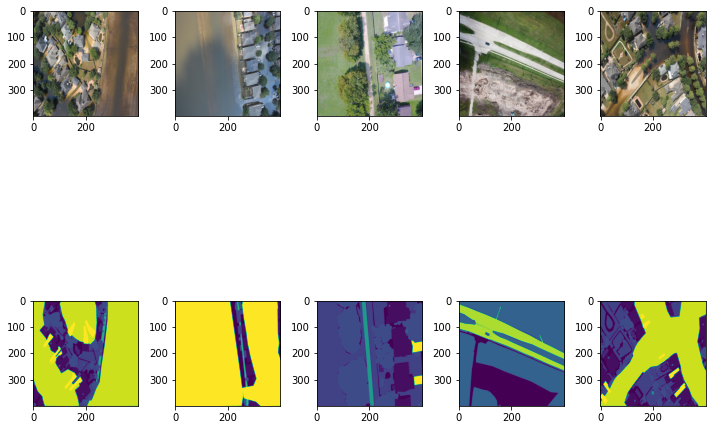

In [ ]:
# Check image & mask after loading
img, mask = next(iter(train_dataloader))
print(img.shape)
print(mask.shape)
f, ax = plt.subplots(2,5, figsize=(10,10))
for c in range(5):
    ax[0][c].imshow(img[c].permute(1, 2, 0))
    ax[1][c].imshow(mask[c])
f.tight_layout()

In [ ]:
# Check number of classification in the mask
label_list =[]
for b in mask:
  for m in b:
    for p in m:
      if p not in label_list:
        label_list.append(p)
print("# distinct pixel (label):",len(label_list))
print("List of distinct pixel (label):")
label_list

# distinct pixel (label): 27
List of distinct pixel (label):


[tensor(16),
 tensor(17),
 tensor(4),
 tensor(0),
 tensor(1),
 tensor(24),
 tensor(22),
 tensor(20),
 tensor(19),
 tensor(18),
 tensor(15),
 tensor(13),
 tensor(14),
 tensor(2),
 tensor(3),
 tensor(5),
 tensor(6),
 tensor(7),
 tensor(8),
 tensor(10),
 tensor(21),
 tensor(23),
 tensor(9),
 tensor(12),
 tensor(11),
 tensor(25),
 tensor(26)]

# 2. Model
Try 3 models: Unet, PSPNet, Deeplabv3

### 2.1 Set up GPU

In [ ]:
# Set up device
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"
print(f"Using {device}.")
if gpu_info.find('failed') >= 0:
  if device == "cpu":
    print('Not connected to a GPU')
else:
  if device == "cuda":
    print(gpu_info)

Using cuda.
Sun Jan 22 18:22:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    34W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                            

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!pwd

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content


### 2.2 Model using Unet

In [ ]:
lr = 0.001
model = smp.Unet(
    encoder_name = 'resnet101', 
    encoder_weights = 'imagenet', 
    classes = 27, 
    activation = None,).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.001)
criterion = nn.CrossEntropyLoss()
epochs = 60

In [ ]:
train_loss_epoch = []
val_loss_epoch = []

for epoch in range(epochs):
    ##TRAINING##
    model.train()
    train_losses_batch = []

    for batch, (img,mask) in enumerate(train_dataloader):
        img,mask = img.to(device),mask.to(device)

        #implement the forward and backward backpropagation
        optimizer.zero_grad()
        mask_pred = model(img)
        loss=criterion(mask_pred, mask)
        loss.backward()
        optimizer.step()
        
        # record the training loss at each batch
        train_losses_batch.append(loss.item())

    train_loss_mean = np.mean(train_losses_batch)
    train_loss_epoch.append(train_loss_mean)

    # Check running
    print("Train epoch",epoch,": finished")

    ##VALIDATION##
    model.eval()
    val_losses_batch = []

    for batch, (img,mask) in enumerate(val_dataloader):
        img,mask = img.to(device),mask.to(device)
   
        # pass the images to the model and calculate the loss
        with torch.no_grad():
          mask_pred = model(img)
          loss=criterion(mask_pred, mask)

        # record the loss at each batch
        val_losses_batch.append(loss.item())

    val_loss_mean = np.mean(val_losses_batch)
    val_loss_epoch.append(val_loss_mean)

    # Print results
    print("Validation epoch",epoch,": finished")

    # Save the model
    torch.save(model.state_dict(), f'Unet_{epoch+1}epoch.pt')

Train epoch 0 : finished
Validation epoch 0 : finished
Train epoch 1 : finished
Validation epoch 1 : finished
Train epoch 2 : finished
Validation epoch 2 : finished
Train epoch 3 : finished
Validation epoch 3 : finished
Train epoch 4 : finished
Validation epoch 4 : finished
Train epoch 5 : finished
Validation epoch 5 : finished
Train epoch 6 : finished
Validation epoch 6 : finished
Train epoch 7 : finished
Validation epoch 7 : finished
Train epoch 8 : finished
Validation epoch 8 : finished
Train epoch 9 : finished
Validation epoch 9 : finished
Train epoch 10 : finished
Validation epoch 10 : finished
Train epoch 11 : finished
Validation epoch 11 : finished
Train epoch 12 : finished
Validation epoch 12 : finished
Train epoch 13 : finished
Validation epoch 13 : finished
Train epoch 14 : finished
Validation epoch 14 : finished
Train epoch 15 : finished
Validation epoch 15 : finished
Train epoch 16 : finished
Validation epoch 16 : finished
Train epoch 17 : finished
Validation epoch 17 : fin

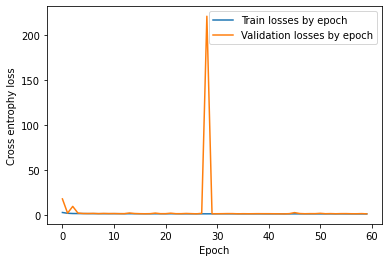

In [ ]:
epoch_list = []
for epoch in range(epochs):
  epoch_list.append(epoch)

plt.plot(epoch_list, train_loss_epoch, label = "Train losses by epoch")
plt.plot(epoch_list, val_loss_epoch, label = "Validation losses by epoch")
plt.xlabel("Epoch")
plt.ylabel("Cross entrophy loss")
plt.legend()
plt.show()

### 2.3 Model using PSPNet

In [ ]:
lr = 0.001
model = smp.PSPNet(
    encoder_name = 'resnet101', 
    encoder_weights = 'imagenet', 
    classes = 27, 
    activation = None,).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.001)
criterion = nn.CrossEntropyLoss()
epochs = 60

In [ ]:
train_loss_epoch = []
val_loss_epoch = []

for epoch in range(epochs):
    ##TRAINING##
    model.train()
    train_losses_batch = []

    for batch, (img,mask) in enumerate(train_dataloader):
        img,mask = img.to(device),mask.to(device)

        #implement the forward and backward backpropagation
        optimizer.zero_grad()
        mask_pred = model(img)
        loss=criterion(mask_pred, mask)
        loss.backward()
        optimizer.step()
        
        # record the training loss at each batch
        train_losses_batch.append(loss.item())

    train_loss_mean = np.mean(train_losses_batch)
    train_loss_epoch.append(train_loss_mean)

    # Check running
    print("Train epoch",epoch,": finished")

    ##VALIDATION##
    model.eval()
    val_losses_batch = []

    for batch, (img,mask) in enumerate(val_dataloader):
        img,mask = img.to(device),mask.to(device)
   
        # pass the images to the model and calculate the loss
        with torch.no_grad():
          mask_pred = model(img)
          loss=criterion(mask_pred, mask)

        # record the loss at each batch
        val_losses_batch.append(loss.item())

    val_loss_mean = np.mean(val_losses_batch)
    val_loss_epoch.append(val_loss_mean)

    # Print results
    print("Validation epoch",epoch,": finished")

    # Save model
    torch.save(model.state_dict(), f'PSPNet_{epoch+1}epoch.pt')

Train epoch 0 : finished
Validation epoch 0 : finished
Train epoch 1 : finished
Validation epoch 1 : finished
Train epoch 2 : finished
Validation epoch 2 : finished
Train epoch 3 : finished
Validation epoch 3 : finished
Train epoch 4 : finished
Validation epoch 4 : finished
Train epoch 5 : finished
Validation epoch 5 : finished
Train epoch 6 : finished
Validation epoch 6 : finished
Train epoch 7 : finished
Validation epoch 7 : finished
Train epoch 8 : finished
Validation epoch 8 : finished
Train epoch 9 : finished
Validation epoch 9 : finished
Train epoch 10 : finished
Validation epoch 10 : finished
Train epoch 11 : finished
Validation epoch 11 : finished
Train epoch 12 : finished
Validation epoch 12 : finished
Train epoch 13 : finished
Validation epoch 13 : finished
Train epoch 14 : finished
Validation epoch 14 : finished
Train epoch 15 : finished
Validation epoch 15 : finished
Train epoch 16 : finished
Validation epoch 16 : finished
Train epoch 17 : finished
Validation epoch 17 : fin

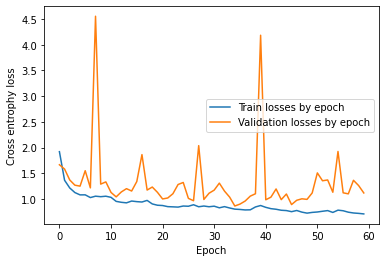

In [ ]:
epoch_list = []
for epoch in range(epochs):
  epoch_list.append(epoch)

plt.plot(epoch_list, train_loss_epoch, label = "Train losses by epoch")
plt.plot(epoch_list, val_loss_epoch, label = "Validation losses by epoch")
plt.xlabel("Epoch")
plt.ylabel("Cross entrophy loss")
plt.legend()
plt.show()

### 2.4 Model using DeepLabV3+

In [ ]:
lr = 0.001
model = smp.DeepLabV3Plus(
    encoder_name = 'resnet101', 
    encoder_weights = 'imagenet', 
    classes = 27, 
    activation = None,).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.001)
criterion = nn.CrossEntropyLoss()
epochs = 80

In [ ]:
train_loss_epoch = []
val_loss_epoch = []

for epoch in range(epochs):
    ##TRAINING##
    model.train()
    train_losses_batch = []

    for batch, (img,mask) in enumerate(train_dataloader):
        img,mask = img.to(device),mask.to(device)

        #implement the forward and backward backpropagation
        optimizer.zero_grad()
        mask_pred = model(img)
        loss=criterion(mask_pred, mask)
        loss.backward()
        optimizer.step()
        
        # record the training loss at each batch
        train_losses_batch.append(loss.item())

    train_loss_mean = np.mean(train_losses_batch)
    train_loss_epoch.append(train_loss_mean)

    # Check running
    print("Train epoch",epoch,": finished")

    ##VALIDATION##
    model.eval()
    val_losses_batch = []

    for batch, (img,mask) in enumerate(val_dataloader):
        img,mask = img.to(device),mask.to(device)
   
        # pass the images to the model and calculate the loss
        with torch.no_grad():
          mask_pred = model(img)
          loss=criterion(mask_pred, mask)

        # record the loss at each batch
        val_losses_batch.append(loss.item())

    val_loss_mean = np.mean(val_losses_batch)
    val_loss_epoch.append(val_loss_mean)

    # Print results
    print("Validation epoch",epoch,": finished")

    # Save model by epoch
    torch.save(model.state_dict(), f'/content/gdrive/My Drive/DL Kaggle project/Ver3_model/Deeplab_80/Deeplabv3_{epoch+1}epoch.pt')

Train epoch 0 : finished
Validation epoch 0 : finished
Train epoch 1 : finished
Validation epoch 1 : finished
Train epoch 2 : finished
Validation epoch 2 : finished
Train epoch 3 : finished
Validation epoch 3 : finished
Train epoch 4 : finished
Validation epoch 4 : finished
Train epoch 5 : finished
Validation epoch 5 : finished
Train epoch 6 : finished
Validation epoch 6 : finished
Train epoch 7 : finished
Validation epoch 7 : finished
Train epoch 8 : finished
Validation epoch 8 : finished
Train epoch 9 : finished
Validation epoch 9 : finished
Train epoch 10 : finished
Validation epoch 10 : finished
Train epoch 11 : finished
Validation epoch 11 : finished
Train epoch 12 : finished
Validation epoch 12 : finished
Train epoch 13 : finished
Validation epoch 13 : finished
Train epoch 14 : finished
Validation epoch 14 : finished
Train epoch 15 : finished
Validation epoch 15 : finished
Train epoch 16 : finished
Validation epoch 16 : finished
Train epoch 17 : finished
Validation epoch 17 : fin

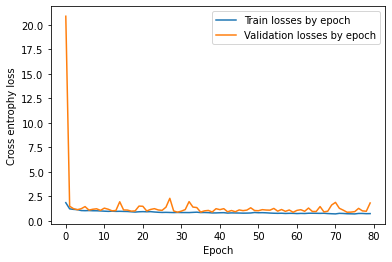

In [ ]:
epoch_list = []
for epoch in range(epochs):
  epoch_list.append(epoch)

plt.plot(epoch_list, train_loss_epoch, label = "Train losses by epoch")
plt.plot(epoch_list, val_loss_epoch, label = "Validation losses by epoch")
plt.xlabel("Epoch")
plt.ylabel("Cross entrophy loss")
plt.legend()
plt.show()

# 3. Checking & extracting the result

### 3.1 Check Unet

In [ ]:
# Load Unet model & extract pred_mask
model = smp.Unet(
    encoder_name = 'resnet101', 
    encoder_weights = 'imagenet', 
    classes = 27, 
    activation = None,)

model.load_state_dict(torch.load("/content/gdrive/My Drive/DL Kaggle project/Ver3_model/Unet_20epoch.pt"))
model.cpu()
img, mask = next(iter(train_dataloader))
output = model(img)
pred_mask  = torch.argmax(output, dim=1)

In [ ]:
# Choosing an image to display
index = 0
img = img[index].cpu()
pred_mask = pred_mask[index].cpu()
true_mask = mask[index].cpu()

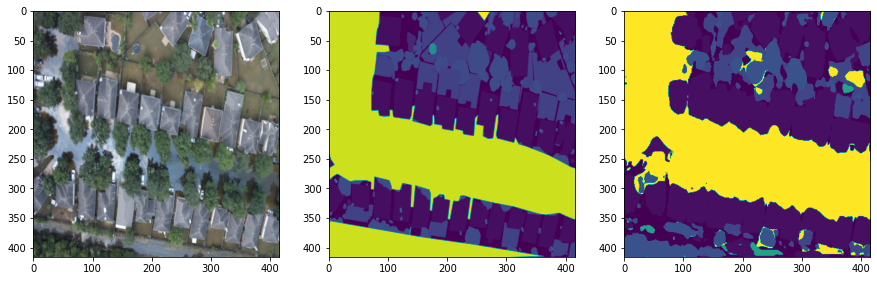

In [ ]:
# Plot
f, ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(img.permute(1,2,0).detach().numpy())
ax[1].imshow(true_mask)
ax[2].imshow(pred_mask)

plt.show()

### 3.2 Check PSPNet

In [ ]:
# Load PSPNet model & extract pred_mask
model = smp.PSPNet(
    encoder_name = 'resnet101', 
    encoder_weights = 'imagenet', 
    classes = 27, 
    activation = None,)

model.load_state_dict(torch.load("/content/gdrive/My Drive/DL Kaggle project/Ver3_model/PSPNet_24epoch.pt"))
model.cpu()
img, mask = next(iter(train_dataloader))
output = model(img)
pred_mask  = torch.argmax(output, dim=1)

In [ ]:
# Choosing an image to display
index = 0
img = img[index].cpu()
pred_mask = pred_mask[index].cpu()
true_mask = mask[index].cpu()

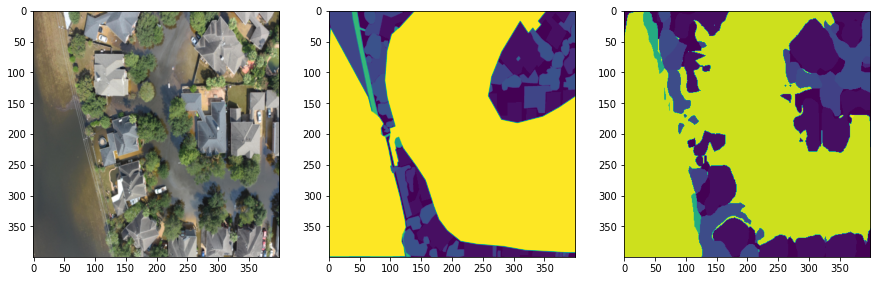

In [ ]:
# Plot
f, ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(img.permute(1,2,0).detach().numpy())
ax[1].imshow(true_mask)
ax[2].imshow(pred_mask)

plt.show()

### 3.3 Check Deeplabv3

In [ ]:
# Load Deeplabv3 model & extract pred_mask
model = smp.DeepLabV3Plus(
    encoder_name = 'resnet101', 
    encoder_weights = 'imagenet', 
    classes = 27, 
    activation = None,)

model.load_state_dict(torch.load("/content/gdrive/My Drive/DL Kaggle project/Ver3_model/Deeplabv3_60epoch.pt"))
model.cpu()
img, mask = next(iter(train_dataloader))
output = model(img)
pred_mask  = torch.argmax(output, dim=1)

In [ ]:
# Choosing an image to display
index = 0
img = img[index].cpu()
pred_mask = pred_mask[index].cpu()
true_mask = mask[index].cpu()

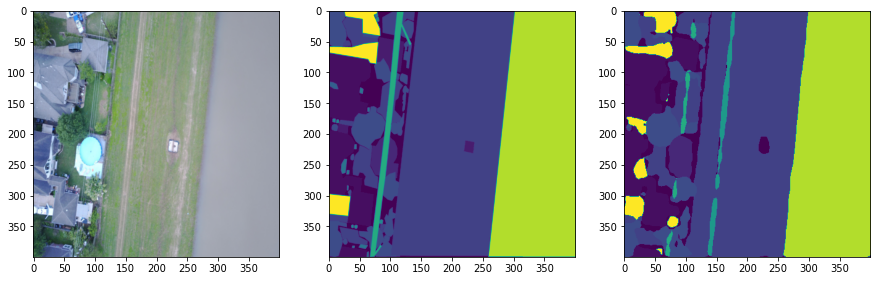

In [ ]:
# Plot
f, ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(img.permute(1,2,0).detach().numpy())
ax[1].imshow(true_mask)
ax[2].imshow(pred_mask)

plt.show()

### 3.4 Predict masks on test set

In [ ]:
# Load the best model
model = smp.DeepLabV3Plus(
    encoder_name = 'resnet101', 
    encoder_weights = 'imagenet', 
    classes = 27, 
    activation = None,).to(device)

model.load_state_dict(torch.load("/content/gdrive/My Drive/DL Kaggle project/Ver3_model/Deeplabv3_60epoch.pt"))

<All keys matched successfully>

In [ ]:
# Create dataloader for test data
class TestSegmentation(Dataset):
    def __init__(self, test_folder_path):
        super(TestSegmentation, self).__init__()
        self.img_files = glob.glob(os.path.join(test_folder_path,'*.tif')) # create a list of train image directory, eg. [test_image/6414.tif, test_image/6427.tif, ...]
        self.transform = transforms.Compose([transforms.Resize((400,400)),transforms.ToTensor()])
        

    def __getitem__(self, index):
        img_path = self.img_files[index]
        img = self.transform(Image.open(os.path.join(img_path)))
        img = img.float()
        img_id = self.img_files[index].split('/')[-1].split('.')[0]
        return img, img_id

    def __len__(self):
        return len(self.img_files)

# Load data
test_folder_path = "test_image"
test_dataset = TestSegmentation(test_folder_path)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle = False)
img, img_id = next(iter(test_dataloader))
print(img.shape)

torch.Size([1, 3, 400, 400])


In [ ]:
!mkdir test_pred

model.eval()
for batch, (img, img_id) in enumerate(test_dataloader):
      img = img.to(device)
      # pass the images to the model and predict the mask
      with torch.no_grad():
        mask_pred = model(img) # predict mask
        mask_pred = torch.argmax(mask_pred, dim=1).squeeze(0).cpu() # combine 27 channels into 1 channel
        mask_pred = np.uint8(mask_pred) # convert into greyscale (before, x255 to avoid longtensor round down)
        test_img = cv2.imread(f'test_image/{img_id[0]}.tif') # load the corresponding test image
        size = (test_img.shape[1], test_img.shape[0]) # Extract the size of the test image
        mask_pred = cv2.resize(mask_pred, size, interpolation = cv2.INTER_NEAREST)
        mask_pred = Image.fromarray(mask_pred)
        mask_pred.save(f"test_pred/{img_id[0]}.png")

mkdir: cannot create directory ‘test_pred’: File exists


In [ ]:
# Check if number of predicted masks is 75
len(os.listdir('test_pred'))

75

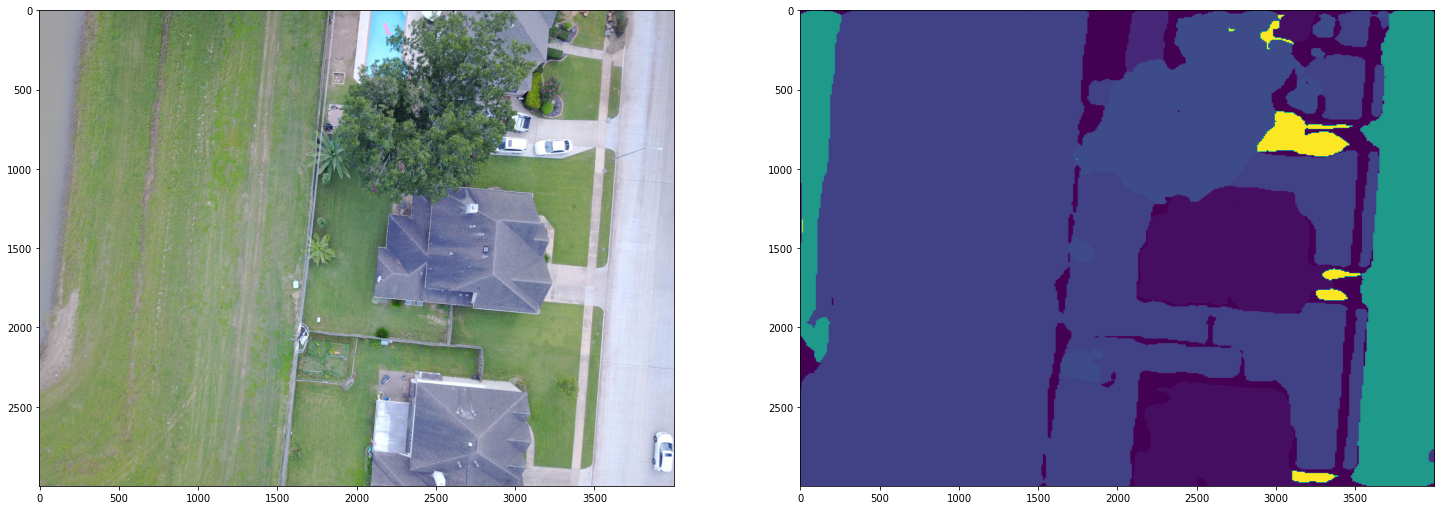

In [ ]:
# Check if image & mask match
f, ax = plt.subplots(1,2, figsize=(25,25))
ax[0].imshow(mpimg.imread('test_image/6414.tif'))
ax[1].imshow(mpimg.imread('test_pred/6414.png'))
plt.show()

In [ ]:
# Compress masks into tar file
tar = tarfile.open("submission.tar", "w")  
for root, dir, files in os.walk('test_pred'):
	for  file in files:
		fullpath = os.path.join(root, file)
		tar.add(fullpath, arcname=file)
tar.close()